In [1]:
# Model agnostic 
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import pandas as pd
from typing import Optional, List, Callable, Dict, Any, List
from pathlib import Path
from utils import ChiefBldr  # custom model for data handling/model trianing

# Model specific 
from xgboost import XGBRegressor
from sklearn.feature_selection import SelectFromModel
from sklearn.pipeline import Pipeline
from typing import Optional, List 

from sklearn.linear_model import LinearRegression

This version of Feyn and the QLattice is available for academic, personal, and non-commercial use. By using the community version of this software you agree to the terms and conditions which can be found at https://abzu.ai/eula.

In [2]:
# Get the directory this file lives in
nb_dir = Path.cwd() # notebook directory
project_root = nb_dir.parents[0] # project directory
data_path = project_root / "datasets" / "processed_well_data.csv"

drop_cols = ['Dia', 'Dev(deg)','Area (m2)', 'z','GasDens','LiquidDens', 'P/T','friction_factor', 'critical_film_thickness', 'Test status', 'Qcr', 'Gasflowrate', 'ΔQ']
D = ChiefBldr(path=data_path, drop_cols=drop_cols, test_size=0.20)

In [3]:
# define xgboost pipeline
def xgboost(
        hparams: Dict[str,Any]
) -> Pipeline:
    
    xgb = XGBRegressor(
        objective="reg:squarederror",
        random_state=42,
        importance_type="gain", 
        **hparams, # ** unravels to sets of key, value 
        )
    # 2) Wrap it in SelectFromModel
    selector = SelectFromModel(
        estimator=xgb,
        threshold="mean",                # keep features with importance ≥ mean importance
        prefit=False                     # will fit selector inside the pipeline
    )

    # 3) Build a pipeline
    pipe = Pipeline([
        ("feature_sel", selector),
        ("model",       xgb),
    ])

    return pipe

hparam_grid = {
            "n_estimators":   [25, 40, 50],
            "learning_rate":  [0.01, 0.05, 0.1],
            "max_depth":      [10, 15, 50],
        }
# train model and optimize hyperparameters via grid search 
trained_model = D.evolv_model(build_model=xgboost, hparam_grid=hparam_grid, k_folds=5)

mask = trained_model.named_steps["feature_sel"].get_support()  
#    ↑ this is a 1d array of True/False of length n_features

# index into column names
selected_features = D.X.columns[mask]

print("Features kept by SelectFromModel:")
print(selected_features.tolist())

Training model and optimizing hyperparameters via k-fold CV...
Done. Best score = 0.7885918003565063
Best hyperparameters: {'n_estimators': 50, 'learning_rate': 0.1, 'max_depth': 15}
Retraining optimized model on full training set


Features kept by SelectFromModel:
['LiquidFlowrate', 'Vsg', 'Vsl', 'Reg', 'd(0,90)', 'd(120,90)']


Training set score: 0.9457831325301205
Test set score: 0.8095238095238095


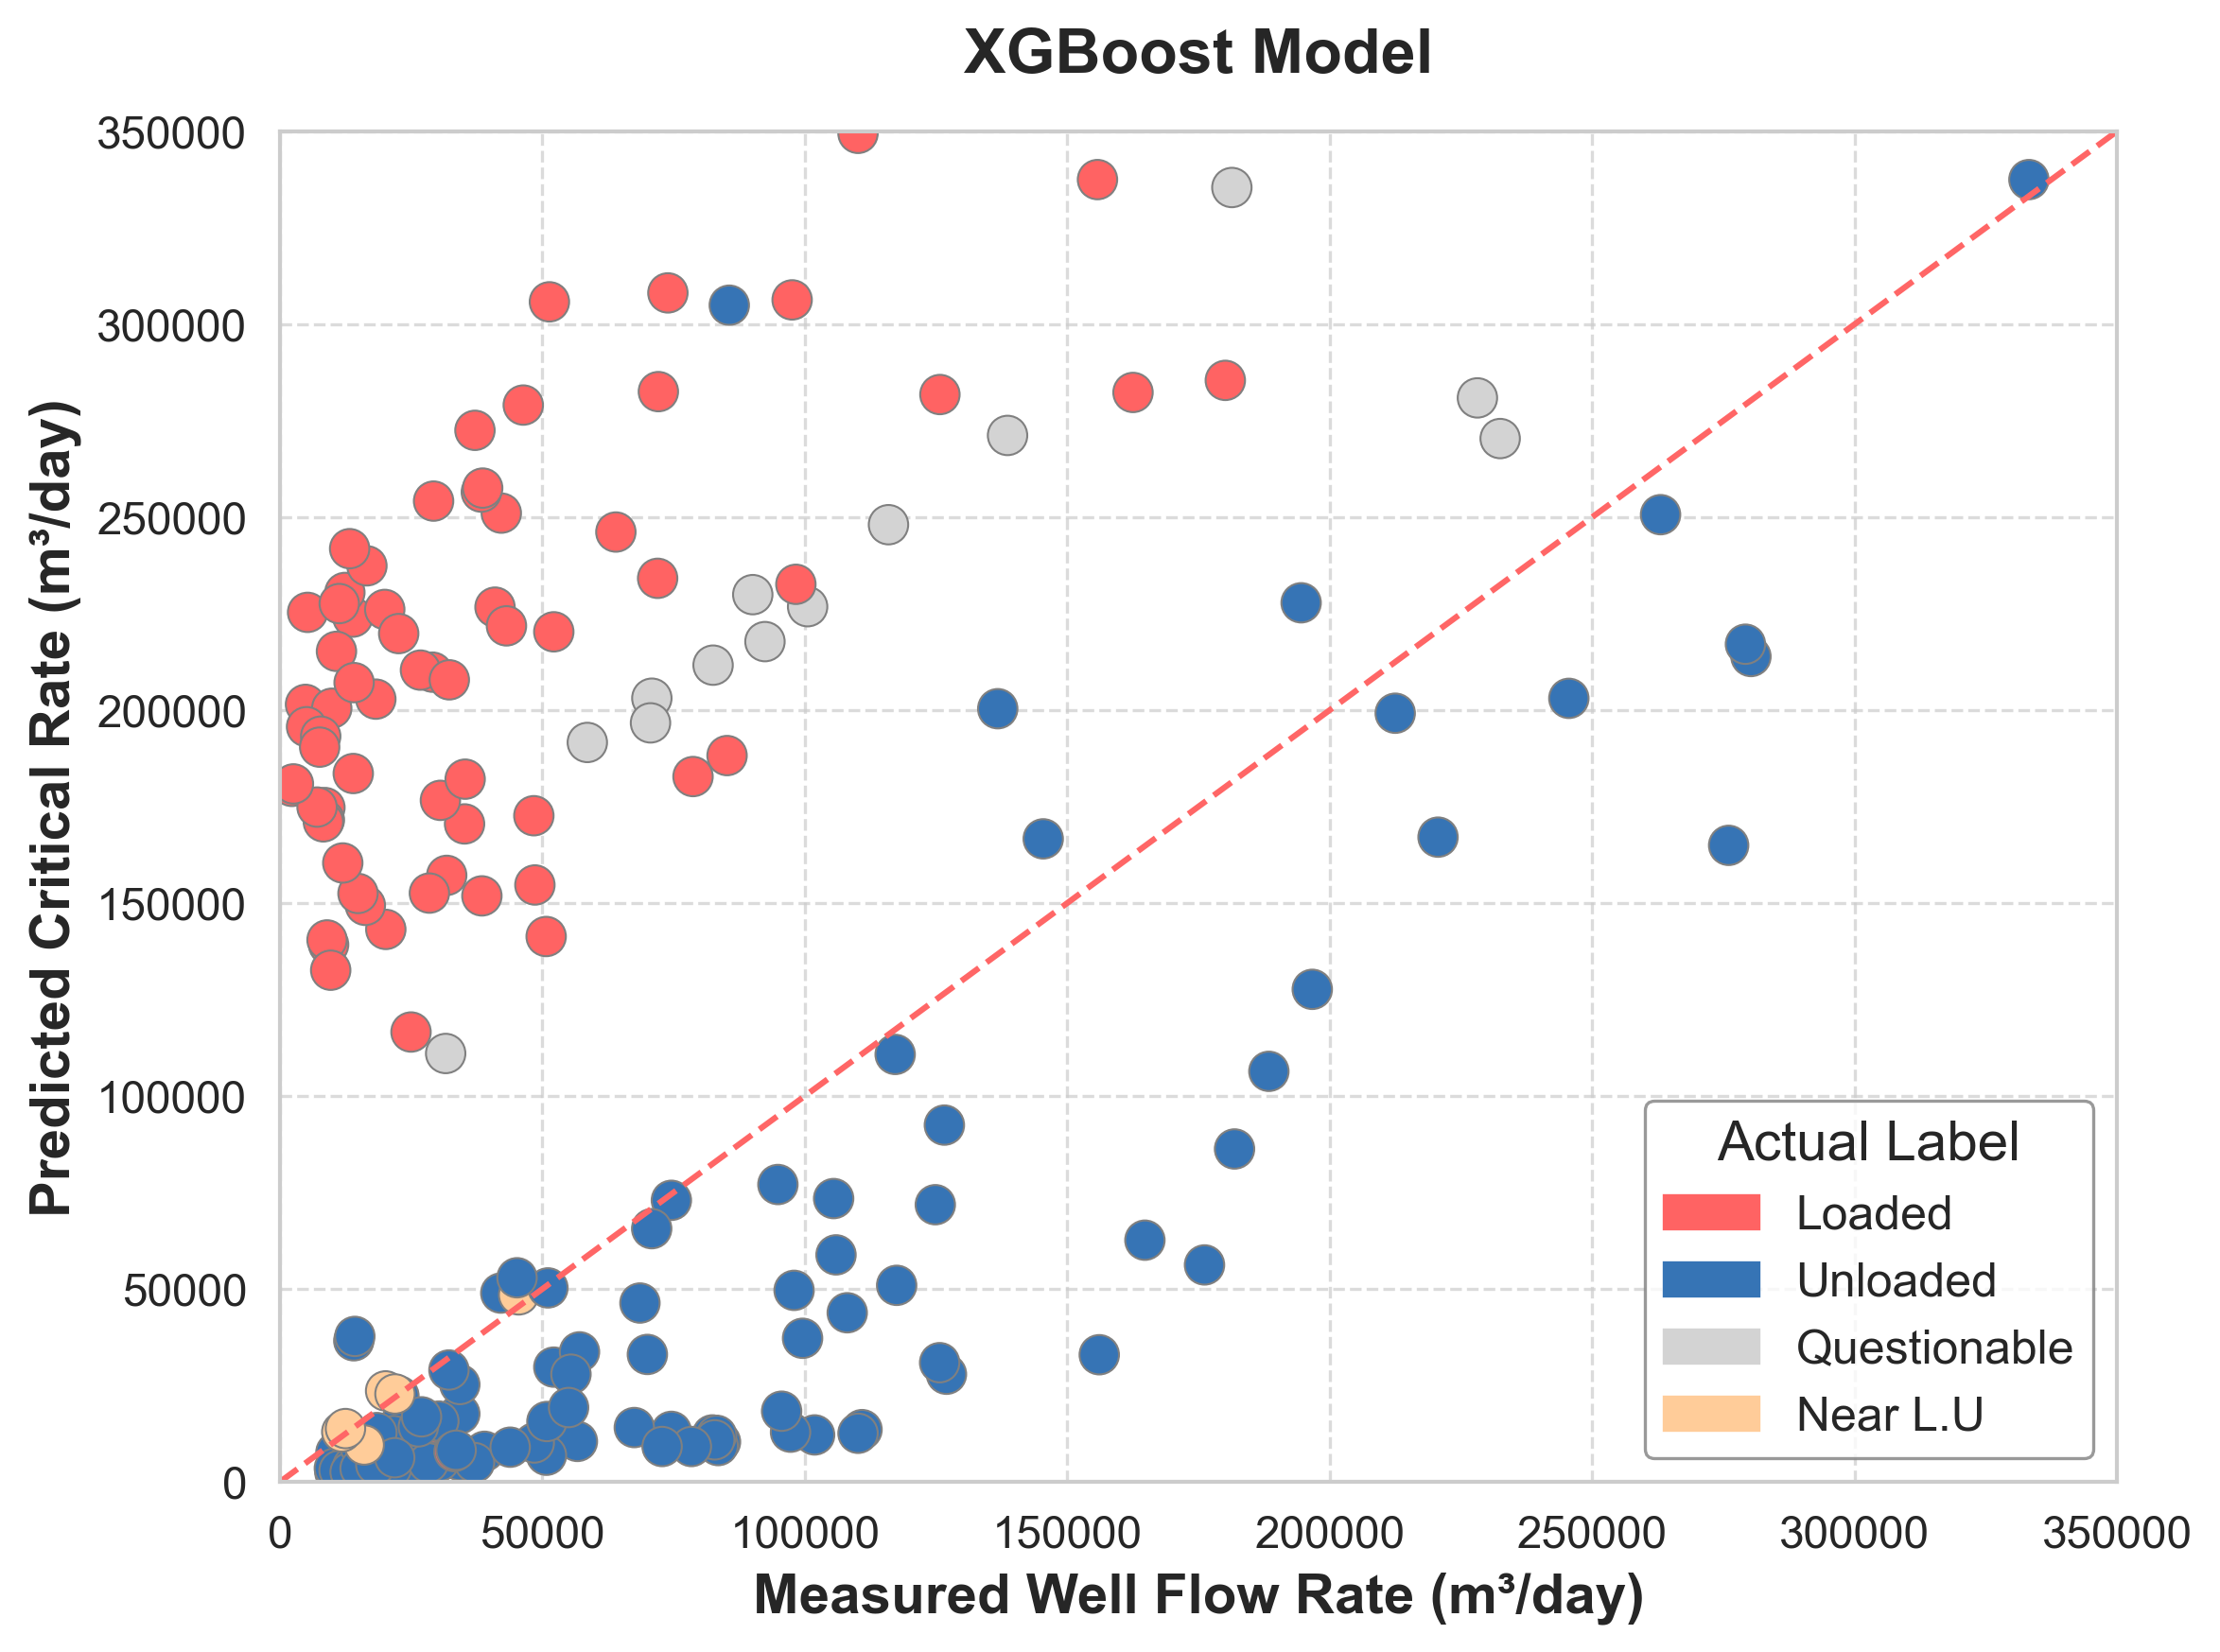

In [4]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import numpy as np

# Set publication-friendly plotting settings
plt.rcParams['text.usetex'] = False
plt.rcParams['font.family'] = 'Arial'  # Publication-friendly font
plt.rcParams['axes.linewidth'] = 0.8
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'

# Define a light, publication-friendly color palette without green
color_map = {
    'Loaded': '#FF6363',  # Light red
    'Unloaded': '#3674B5',  # Light purple
    'Questionable': '#D3D3D3',  # Light orange
    'Near L.U': '#FFCC99'  # Light blue
}

colors = D.status_col.map(color_map).fillna('#D3D3D3')  # Light gray for missing values
y_pred_scaled = trained_model.predict(D.X_scaled)
y_pred = D.scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()
plt.figure(figsize=(8, 6), dpi=300)
sns.set_theme(style="whitegrid", context="paper", font_scale=1.3, font='Arial')
plt.scatter(D.gsflow , y_pred, c=colors, alpha=1, s=100, edgecolors="gray", linewidth=0.5)
plt.plot([0, 350000], [0, 350000], '--', color='#FF6666', linewidth=1.5)  # Light red dashed line
plt.title("XGBoost Model", fontsize=16, fontweight='bold', pad=15)
plt.xlabel("Measured Well Flow Rate (m³/day)", fontsize=14, fontweight='bold')
plt.ylabel("Predicted Critical Rate (m³/day)", fontsize=14, fontweight='bold')
plt.grid(True, linestyle='--', alpha=0.7)
plt.xlim(0, 350000)
plt.ylim(0, 350000)
legend_patches = [mpatches.Patch(color=color, label=status) for status, color in color_map.items()]
plt.legend(handles=legend_patches, title='Actual Label', fontsize=12, title_fontsize=14, 
           loc='best', frameon=True, edgecolor='gray')
plt.tight_layout()
plt.savefig("xgboost_scatter.pdf", format="pdf", dpi=300, bbox_inches='tight')
plt.show()
plt.close()

(105,)
(105,)
(105, 25)
(105,)
(105,)


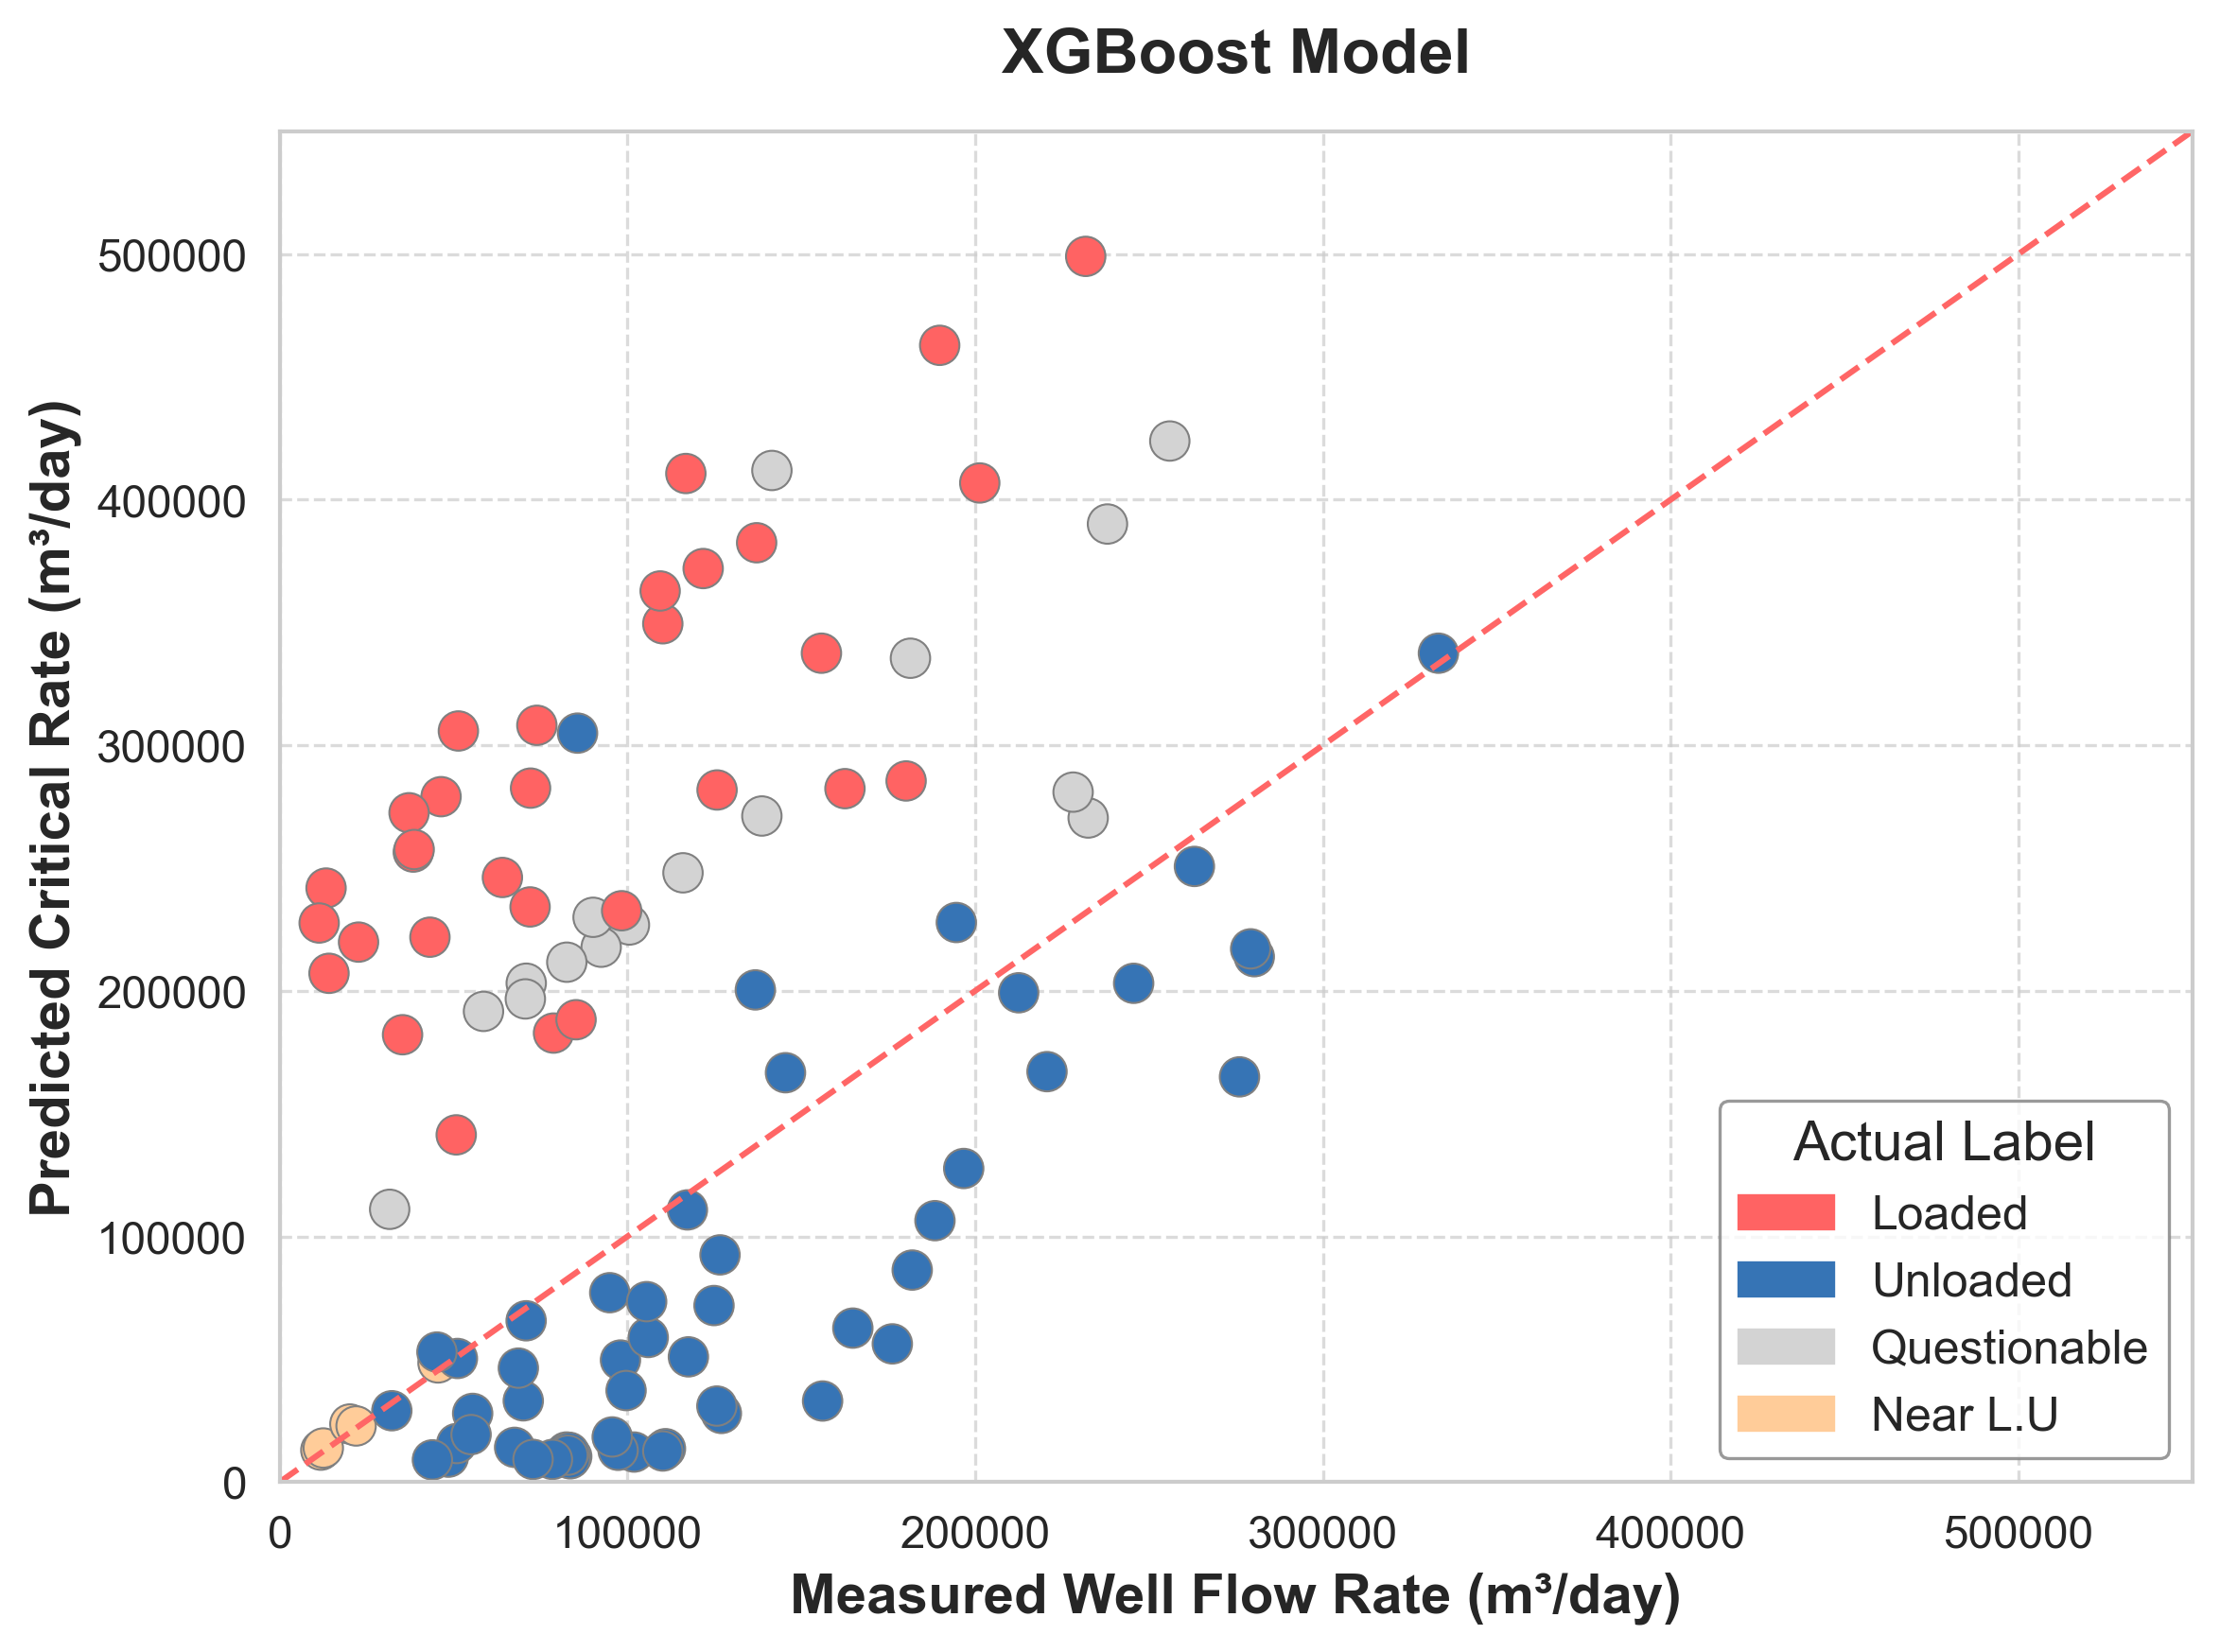

In [17]:

#Application to Turner

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import numpy as np

# Set publication-friendly plotting settings
plt.rcParams['text.usetex'] = False
plt.rcParams['font.family'] = 'Arial'  # Publication-friendly font
plt.rcParams['axes.linewidth'] = 0.8
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'

# Define a light, publication-friendly color palette without green
color_map = {
    'Loaded': '#FF6363',  # Light red
    'Unloaded': '#3674B5',  # Light purple
    'Questionable': '#D3D3D3',  # Light orange
    'Near L.U': '#FFCC99'  # Light blue
}


cols = ['LiquidFlowrate', 'Vsg', 'Vsl', 'Reg', 'd(0,90)', 'd(120,90)']

subset_df = D.df.iloc[103:209]

# subset_x_scaled = D.scaler_X.transform(subset_df[cols])
color_subset = subset_df['Test status'].map(color_map).fillna('#D3D3D3')  # Light gray for missing values
print(color_subset.shape)
# y_pred_scaled = trained_model.predict(subset_x_scaled)
# y_pred = D.scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()


colors = D.status_col.map(color_map).fillna('#D3D3D3')  # Light gray for missing values
X = D.X.iloc[103:209]
print(subset_df['Gasflowrate'].shape)
print(D.scaler_X.transform(X).shape)
y_pred_scaled = trained_model.predict(D.scaler_X.transform(X))
print(y_pred_scaled.shape)
y_pred = D.scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()
print(y_pred.shape)

plt.figure(figsize=(8, 6), dpi=300)
sns.set_theme(style="whitegrid", context="paper", font_scale=1.3, font='Arial')
plt.scatter(subset_df['Gasflowrate'] , y_pred, c=color_subset , alpha=1, s=100, edgecolors="gray", linewidth=0.5)
plt.plot([0, 550000], [0, 550000], '--', color='#FF6666', linewidth=1.5)  # Light red dashed line
plt.title("XGBoost Model", fontsize=16, fontweight='bold', pad=15)
plt.xlabel("Measured Well Flow Rate (m³/day)", fontsize=14, fontweight='bold')
plt.ylabel("Predicted Critical Rate (m³/day)", fontsize=14, fontweight='bold')
plt.grid(True, linestyle='--', alpha=0.7)
plt.xlim(0, 550000)
plt.ylim(0, 550000)
legend_patches = [mpatches.Patch(color=color, label=status) for status, color in color_map.items()]
plt.legend(handles=legend_patches, title='Actual Label', fontsize=12, title_fontsize=14, 
           loc='best', frameon=True, edgecolor='gray')
plt.tight_layout()
plt.savefig("xgboost_scatter.pdf", format="pdf", dpi=300, bbox_inches='tight')
plt.show()
plt.close()